In [1]:
import nltk; nltk.download('stopwords')
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim import similarities

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/michellexiong/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
%store -r data_lemmatized
%store -r model_list

### Data pre-processing 

In [6]:
#NLTK Stopwords 
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [8]:
#Import dataset as dataframe
df = pd.read_csv("street.csv")

#Combine title, slug, and content
df['all_text'] = df["title"].map(str) + ' ' + df['slug'] + ' ' + df['content']

In [5]:
#convert to list of lyrics
data = df.all_text.values.tolist()

In [6]:
#function to tokenize lyrics
def text_to_words(text):
    for article in text:
         # simple_preprocess converts documents into list of lowercase tokens, deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(article), deacc=True))  
        
#create list of list of words in each song         
data_words = list(text_to_words(data))

In [6]:
#print(data_words[:1])

In [7]:
#optional- few important bigrams and trigrams found in lyrics data
#Build bigram and trigram models - two or three words frequently occuring together in document
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) 
trigram = gensim.models.Phrases(bigram[data_words], threshold=100) 

#Faster way to access trigrams and bigrams
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

#define function for bigrams
def make_bigrams(content):
    return[bigram_mod[article] for article in content]

#define function for trigrams
def make_trigrams(content):
    return[trigram_mod[bigram_mod[article]] for article in content]

In [8]:
# Define function to remove stopwords
def remove_stopwords(text):
    #create list with every word in a song if they are not stop word for every song in lyrics list
    return [[word for word in simple_preprocess(str(article)) if word not in stop_words] for article in text]

#define lemmatization function
def lemmatization(text, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for entry in text:
        #nlp object spacy 
        article = nlp(" ".join(entry))
        texts_out.append([word.lemma_ for word in article if word.pos_ in allowed_postags])
    return texts_out

In [9]:
#call stopwords function
data_words_nostops = remove_stopwords(data_words)

In [10]:
#print(data_words_nostops[:1])

In [11]:
#optional - call function to make bigrams for dataset
data_words_bigrams = make_bigrams(data_words_nostops)

In [12]:
#call lemmatize function
nlp = spacy.load('en', disable=['parser', 'ner'])
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [13]:
%store data_lemmatized

Stored 'data_lemmatized' (list)


In [13]:
#print(data_lemmatized[:1])

### Bag of words similarity matrix

In [3]:
#create Dictionary for topic modelling which assigns unique id for each word in lyrics data
id2word = corpora.Dictionary(data_lemmatized)

#create Corpus
texts = data_lemmatized

#Term document frequency, corpus is list of list of tuples in which word id x occurs y times in song
corpus = [id2word.doc2bow(t) for t in texts]


In [20]:
#df.head()

list

In [30]:
index = similarities.MatrixSimilarity(corpus, num_features=len(id2word), num_best = 200)

In [10]:
def recommender (query):
    recs = []
    i = df.index[df['id'] == query].tolist()[0]
    words = data_lemmatized[i]
    query_vector = id2word.doc2bow(words)
    sims = index[query_vector]
    return sims

In [11]:
def see_recs(sims):
    count = 0
    recs = []
    for r in sims:
        i = r[0]
        article = df.iloc[i]['title'] + " " + str(r[1])
        if article not in recs:
            recs.append(article)
            count += 1
            if count == 10:
                break                                                                     
    pprint(recs)

In [39]:
see_recs(recommender(37013))

['The Oscars Once Again Prove Outdated and Irrelevant 1.0',
 "Deconstructing Diversity in this Year's 'Best Director' Nominations "
 '0.6139607429504395',
 "The Oscars are a Man's World 0.5136854648590088",
 'Oscar Nominations: The Biggest Snubs and Surprises 0.5058308839797974',
 'Oscars Firsts: Celebrating Women Behind the Camera 0.4797067940235138',
 "Street's Predictions for the 91st Academy Awards  0.46004679799079895",
 'Oscars 2014: Five Biggest Snubs 0.44958004355430603',
 "Charlize theron's golden globes 0.44917550683021545",
 "The Oscars' 'Best Popular Film' Award: Blurring the Lines Between Commercial "
 'and Artistic Success 0.43383675813674927',
 'How to Make an Oscar–Winning Film 0.4062246084213257']


In [40]:
see_recs(recommender(37011))

['Frances Quinlan Comes Full Circle in Her Solo Debut 1.0',
 '10 Songs Instrumental to our Experiences  0.5275651216506958',
 'Interviewing Waterparks Frontman Awsten Knight 0.4949963092803955',
 'Street Writers Choose Their Desert Island Discs 0.48726117610931396',
 'Queen of the Hill Meets the Hippest Cat in Town 0.4734741747379303',
 "'Nation of Two' by Vance Joy Doesn't Hold Up 0.470693439245224",
 'You Should Know About: Cullen Omori 0.4648980498313904',
 'And The Album Of The Year Is... 0.4648503065109253',
 'Interview: Atlas Genius 0.4570596218109131',
 "Mannequin Pussy Aren't What You Expect 0.45556217432022095"]


In [41]:
see_recs(recommender(35967))

['Meet Tori Borlase: The UA Representative Who Organized the Philadelphia '
 'Climate Strike 1.0000001192092896',
 'Caution vs. Revolution: The Divide on Climate Change 0.4000192880630493',
 "Don't Argue With Anish Welde, Penn's Top Novice Debater  0.3891429305076599",
 'Not Enough  0.37514394521713257',
 'I Went Back to High School, and It Felt Like I Was Still at Penn  '
 '0.3673226833343506',
 'Meet Natasha Menon, Your New UA President 0.3665757179260254',
 'Ego of the Week: Connor Swords 0.3633180856704712',
 'JMHH Awards: Students Breaking Wharton Stereotypes  0.36320754885673523',
 'Penn 10: Krisna Maddy 0.36231887340545654',
 'From the West Bank to West Philadelphia  0.36064159870147705']


In [42]:
see_recs(tfidf_recommender(35967))

['Meet Tori Borlase: The UA Representative Who Organized the Philadelphia '
 'Climate Strike 0.8200399875640869',
 'Caution vs. Revolution: The Divide on Climate Change 0.27989792823791504',
 'Ego of the Week: Connor Swords 0.23656034469604492',
 'I Went Back to High School, and It Felt Like I Was Still at Penn  '
 '0.22411540150642395',
 "Qu'est-ce Que C'est Chick-Lit? 0.2205362766981125",
 'Ego of the Week: Nicolas Garcia 0.2145242989063263',
 'Not Enough  0.2085728794336319',
 "Don't Argue With Anish Welde, Penn's Top Novice Debater  0.199131578207016",
 'Ego of the Week: Jordan Williams  0.19467931985855103',
 'Ego of the Week: Nicholas Escobar 0.1915401965379715']


In [40]:
see_recs(recommender(35451))

['Can Cakes and Sweaters Enact Political Change?',
 'How Your Insta Feed Can Boost Your Self Esteem ',
 'Open Studios Preview: Out in the Open with Nowhere to Hide',
 'Art and Politics: An Introduction',
 'The Best Ways to Eat Your Booze',
 'The Insta–Famous Food Blogs of Penn You Need to Follow',
 "Celebrate Women's History Month in Philadelphia",
 "What to Read After Finishing Michelle Obama's 'Becoming'",
 "Revisiting 'All The President’s' Men In Light of 'The Post'",
 'How to Spend Your Day in Old City']


In [35]:
see_recs(tfidf_recommender(35451))

['Can Cakes and Sweaters Enact Political Change?',
 "Celebrate Women's History Month in Philadelphia",
 'How Your Insta Feed Can Boost Your Self Esteem ',
 'The Insta–Famous Food Blogs of Penn You Need to Follow',
 'How to Prove You’re Open–Minded to That Facebook Friend You Haven’t Seen in '
 'Five Years',
 'Open Studios Preview: Out in the Open with Nowhere to Hide',
 'The Best Ways to Eat Your Booze',
 'How to Spend Your Day in Old City',
 'Baked Girl: Five-Minute Mug Cakes',
 "What to Read After Finishing Michelle Obama's 'Becoming'"]


In [19]:
see_recs(recommender(30372))

['Overheards 11.17.16',
 'Overheard at Penn: 03.17.2011',
 'Overheards: 10.23.14',
 'Overheard at Penn: 3.14.13',
 'Best campus eatery to find a cute girl',
 'SHOUTOUTS. Fall 2011',
 "Is 'Tall Girl' Really that Bad?",
 'Word on the Street: Everybody Has a Story',
 'OVERHEARDS 3.24.16',
 'Overheard at Penn: 1.17.13']


In [43]:
see_recs(tfidf_recommender(30372))

['Overheards 11.17.16 0.8232963681221008',
 'Overheards: 10.23.14 0.2453722357749939',
 'Overheard at Penn: 03.17.2011 0.22762887179851532',
 'On Getting Cut 0.1869812160730362',
 'An Open Letter to Sad Freshmen Girls 0.1767139732837677',
 'Street Shout-Outs 0.1733660101890564',
 'Shoutouts Fall 2006 0.1727592647075653',
 'No Valentine, No Problem 0.17058919370174408',
 'DO YOU HAVE AN ANONYMOUS ROMANCE-RELATED MESSAGE FOR ANYONE AT PENN? '
 '0.1669594943523407',
 'On Getting Cut 0.16638025641441345']


### TF-IDF

In [20]:
tfidf = gensim.models.TfidfModel(corpus)

In [27]:
tfidf_index = similarities.MatrixSimilarity(tfidf[corpus], num_features=len(id2word), num_best = 200)

In [28]:
def tfidf_recommender (query):
    recs = []
    i = df.index[df['id'] == query].tolist()[0]
    words = data_lemmatized[i]
    query_vector = id2word.doc2bow(words)
    sims = tfidf_index[query_vector]
    return sims

In [29]:
see_recs(tfidf_recommender(37013))

['The Oscars Once Again Prove Outdated and Irrelevant',
 "Deconstructing Diversity in this Year's 'Best Director' Nominations",
 "The Oscars are a Man's World",
 'Oscars Firsts: Celebrating Women Behind the Camera',
 'Oscar Nominations: The Biggest Snubs and Surprises',
 'Which Best Picture Nomination Speaks to Your Soul?',
 'Is the "Oscar Curse" Real? ',
 "The Oscars' 'Best Popular Film' Award: Blurring the Lines Between Commercial "
 'and Artistic Success',
 "Charlize theron's golden globes",
 'How to Make an Oscar–Winning Film']


### Training LDA Model

In [1]:
#build LDA Model with ten topics
lda_model50 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=50, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [30]:
%store lda_model50

Stored 'lda_model50' (LdaModel)


In [24]:
%store -r lda_model50

In [25]:
coherence_model = CoherenceModel(model=lda_model50, texts=data_lemmatized, dictionary=id2word, coherence='c_v')

In [26]:
coherence = coherence_model.get_coherence()
print('\nCoherence Score: ', coherence)


Coherence Score:  0.4861981110531002


In [31]:
#Print the Keywords in the 10 topics
pprint(lda_model50.print_topics(num_words=10))

[(32,
  '0.094*"stewart" + 0.076*"army" + 0.069*"ica" + 0.055*"carter" + '
  '0.040*"klein" + 0.031*"leo" + 0.021*"laboratory" + 0.021*"decay" + '
  '0.013*"summary" + 0.005*"winding"'),
 (20,
  '0.192*"celebrity" + 0.144*"lip" + 0.082*"makeup" + 0.069*"catholic" + '
  '0.024*"cosmetic" + 0.008*"appliance" + 0.004*"halo" + 0.000*"warmup" + '
  '0.000*"mesoamerican" + 0.000*"perineum"'),
 (28,
  '0.118*"toy" + 0.077*"mexico" + 0.074*"marathon" + 0.065*"sincere" + '
  '0.045*"neil" + 0.042*"maggie" + 0.037*"reunion" + 0.035*"ian" + '
  '0.029*"lawn" + 0.028*"down"'),
 (44,
  '0.182*"web" + 0.130*"lisa" + 0.076*"ipod" + 0.051*"beyonce" + 0.048*"mic" + '
  '0.045*"essential" + 0.039*"poet" + 0.016*"regain" + 0.011*"subversive" + '
  '0.009*"proactive"'),
 (0,
  '0.108*"butter" + 0.085*"peanut" + 0.072*"veteran" + 0.051*"geek" + '
  '0.032*"pc" + 0.031*"hannah" + 0.028*"tang" + 0.023*"caroline" + '
  '0.021*"perry" + 0.018*"eating"'),
 (48,
  '0.181*"creek" + 0.137*"skin" + 0.127*"france" +

Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 398, in _send_bytes
    self._send(buf)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 397, in _send_bytes
    self._send(header)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _s

KeyboardInterrupt: 

In [28]:
coherence_model_lda = CoherenceModel(model=lda_model50, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 398, in _send_bytes
    self._send(buf)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 397, in _send_bytes
    self._send(header)
  File "/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _s


Coherence Score:  0.5002622792059759


In [31]:
#coherence_lda

In [22]:
#function to export topics as csv with keywords displayed incolumns 
def topics_to_df(model_topics):
    top_index = []
    keywords = []
    for top, words in model_topics:
        top_index.append(top)
        keywords_separated = gensim.utils.simple_preprocess(words)
        keywords.append(keywords_separated)
    df_topics = pd.DataFrame(keywords)
    df_topics = df_topics.transpose()
    df_topics.columns = top_index
    return df_topics

In [38]:
topics10_df = topics_to_df(topics10)
#topics10_df.to_csv('lyrics_ldamodel_10', index=None, header=True)

In [8]:
#build LDA model 40 topics
lda_model40 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=40, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

Stored 'lda_model40' (LdaModel)


In [16]:
lda_40 = topics_to_df(lda_model40.print_topics(num_topics=40, num_words=20))
#lda_40.to_csv('lda40_keywords.csv')

In [17]:
#build LDA model 20 topics
lda_model20 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
lda_20 = topics_to_df(lda_model20.print_topics(num_topics=20, num_words=20))
#lda_20.to_csv('lda20_keywords.csv')

In [18]:
#store desired topic models to be used in next steps
%store lda_model10
%store lda_model40
%store lda_model20

Stored 'lda_model20' (LdaModel)


### Model analysis

In [23]:
# Compute Perplexity
print('\nPerplexity: ', lda_model10.log_perplexity(corpus))  #lower the better.

# Compute Coherence Score between zero and one higher the better
coherence_model_lda = CoherenceModel(model=lda_model10, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.4099813070531555

Coherence Score:  0.39791162285705894


In [29]:
#create models with different number of topics and compute coherence, takes some time
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=False)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [30]:
#call function to generate list of models- set start, step and limit
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=10, limit=100, step=5)

In [35]:
coherence_values

[0.5085940577923722,
 0.5268261101848211,
 0.5170557519650683,
 0.5076504914960591,
 0.4905865017610599,
 0.4811363186903156,
 0.49117589638704723,
 0.4731400427598802,
 0.48352880760582295,
 0.49405675153989365,
 0.46180709007441967,
 0.47153943278608235,
 0.47290154854168903,
 0.448053443835022,
 0.46565254835150577,
 0.4610292150405999,
 0.4832309098903623,
 0.4491806070073582]

In [32]:
#store for future use
%store model_list

Stored 'model_list' (list)


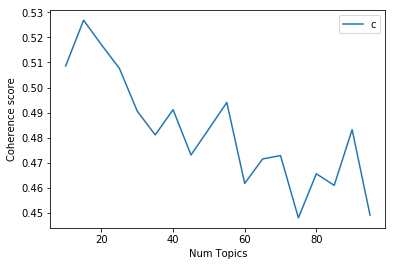

In [37]:
# Show graph of number of topics vs coherence 
limit=100; start=10; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [39]:
coherence_values

[0.5085940577923722,
 0.5268261101848211,
 0.5170557519650683,
 0.5076504914960591,
 0.4905865017610599,
 0.4811363186903156,
 0.49117589638704723,
 0.4731400427598802,
 0.48352880760582295,
 0.49405675153989365,
 0.46180709007441967,
 0.47153943278608235,
 0.47290154854168903,
 0.448053443835022,
 0.46565254835150577,
 0.4610292150405999,
 0.4832309098903623,
 0.4491806070073582]

In [4]:
model15 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=15, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=False)

In [51]:
model_list[1]

In [45]:
#pprint(model_list[1].print_topics(num_words=10))

In [5]:
lda = model15

In [6]:
lda_index = similarities.MatrixSimilarity(lda[corpus],num_features=len(id2word), num_best = 200)

In [17]:
def lda_recommender (query):
    recs = []
    i = df.index[df['id'] == query].tolist()[0]
    words = data_lemmatized[i]
    query_vector = id2word.doc2bow(words)
    sims = lda_index[query_vector]
    return sims

In [18]:
see_recs(lda_recommender(37013)) #oscars article

['Album Review: “Frozen Throne”—Groundislava\n 0.11934711039066315',
 'How Astroworld Broke Hip Hop’s Weak Streak 0.11912423372268677',
 'Album Review: "Dream Your Life Away"—Vance Joy 0.11858555674552917',
 "Listen to This: 'Atlanta' Soundtrack Highlights 0.11853858083486557",
 'REVIEW: Avey Tare, Down There 0.11806224286556244',
 "Amy Winehouse and Nas Duet on Salaam Remi's New Song 0.11794278025627136",
 'Review: "Battle Born” — The Killers 0.1177503690123558',
 'Album Review: "Sweet Talker"—Jessie J 0.11704496294260025',
 'Toro Y Moi — "Anything in Return"  0.11701808124780655',
 'Review: Kanye West, “My Beautiful Dark Twisted\xa0Fantasy” '
 '0.11691488325595856']


In [19]:
see_recs(lda_recommender(37011)) #France Quinlan comes full circle

['Vote for your 2014 Senior Superlatives 0.2072090059518814',
 "Valentine's Day DIY Poll 0.18919692933559418",
 'Vote For Senior Superlatives 2K16 0.16972923278808594',
 'Vote for Best of Penn: 2012 0.16848856210708618',
 'Vote for your Tweet of the Week: 2/14-2/21 0.16098614037036896',
 'Vote for Your Tweet of the Week: 11/8 0.1609855592250824',
 'Vote for Your Tweet of the Week: 2/7 - 2/14  0.1609855592250824',
 'Vote for Your Tweet of the Week: 1/26 0.16098244488239288',
 'Vote for your Tweet of the Week 11/15-11/22 0.1609824001789093',
 'Vote For Your Tweet of the Week: 1/31-2/7 0.16098226606845856']
